# Search precursor for optimal time window

In [1]:
import pandas as pd
import numpy as np
import io
import scipy as sp
import scipy.fftpack
#import scipy.fft
import scipy.signal as signal
from scipy.signal import butter, lfilter, freqz, filtfilt, cheby2
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
#import h5py
#import windspectra as ws
#import PyOctaveBand
from matplotlib.font_manager import FontProperties

In [2]:
# Plot standardize
def showplot(axis=0,ls=1.5):
    plt.rcParams.update({'font.size': 18})
    #### Get handles and print plot ####
    handles, labels = ax[axis].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(ls, 0.6),frameon=False,prop={'size': 14})
    for i,a in enumerate(ax):
        #a.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.5)
        a.minorticks_on()
        #a.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
        a.grid(True)
        #for tick in a.get_xticklabels():
        #    tick.set_fontname("Open Sans")
        #for tick in a.get_yticklabels():
        #    tick.set_fontname("Open Sans")
    fig.tight_layout()
    plt.show()

In [3]:
amrwindfedirs = ['../',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/utilities',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

import extractTimeSeries2 as eTS

## Create the CSV file

In [4]:
def datadict2csv(datadict, ptlist, filename, varlist=['velocityx','velocityy','velocityz']):
    header="Time coordinates[0] coordinates[1] coordinates[2] velocity_probe[0] velocity_probe[1] velocity_probe[2]\n"
    # get the time coordinate
    timevec = datadict[ptlist[0]]['time']
    with open(filename, 'w') as f:
        f.write(header)
        for  itime, t in enumerate(timevec):
            for pt in ptlist:
                p = datadict[pt]
                f.write('%f %f %f %f '%(t, p['x'], p['y'], p['z']))
                for v in varlist:
                    f.write('%f '%p[v][itime])
                f.write('\n')

In [5]:
ncfile='/lustre/orion/cfd162/scratch/lcheung/ALCC_Frontier_WindFarm/MedWS_LowTI/precursor6_4kmX2km_5m/post_processing/sampling60000.nc'
# These are the locations of the domain center at lower rotor tip, hub-height, and upper rotor tip
# NOTE: they should be in sample plane indices, not physical coordinates
pt1 = (456,200,0)
pt2 = (456,200,1)
pt3 = (456,200,2)
ptlist=[pt1, pt2, pt3]
datfile='MedWS_LowTI_4x2.dat'
writedat=True

In [6]:
if writedat:
    data=eTS.extractpt(ncfile,ptlist, timesubset=None)
    datadict2csv(data, ptlist, datfile)

[============================================================] 100.0% 


## Load Precursor Data

In [7]:
precDataFile = {
    #"run1" : "./Probe_Turbine1_0.dat", 
    #"run1" : "./turbine1.dat", 
    "run1" : datfile, 
}

precData = {}

for c in precDataFile.keys():
    precData[c] = pd.read_csv(precDataFile[c],delim_whitespace=True,index_col=False)

preI = list(precDataFile.keys())

In [8]:
precData['run1']

,Time,coordinates[0],coordinates[1],coordinates[2],velocity_probe[0],velocity_probe[1],velocity_probe[2]
0,24000.0,2280.0,1000.0,30.0,6.820698,0.135600,0.075962
1,24000.0,2280.0,1000.0,150.0,8.696408,-0.239348,0.023998
2,24000.0,2280.0,1000.0,270.0,9.892207,-1.027472,-0.015647
3,24000.4,2280.0,1000.0,30.0,6.764152,0.088970,0.057259
4,24000.4,2280.0,1000.0,150.0,8.665867,-0.138888,0.003904
...,...,...,...,...,...,...,...
44998,29999.6,2280.0,1000.0,150.0,8.955337,0.075259,-0.037845
44999,29999.6,2280.0,1000.0,270.0,9.901608,-1.497560,-0.004111
45000,30000.0,2280.0,1000.0,30.0,6.888153,0.418510,-0.023084
45001,30000.0,2280.0,1000.0,150.0,8.934438,0.149769,-0.080606


## Search Precursor Data

In [9]:
#############################################
### User Input 
#############################################
prData = precData['run1']

dt = 0.4       # sim output time step
it = precData['run1'].Time[0]    # initial time
nt = len(np.array(prData['Time'][(prData['coordinates[2]']==150.000000)]))  # number of timesteps
#nt = len(np.array(prData['Time']))
print("nt: ",nt)
bt = 15       # bin time length in minutes
bl = bt*60/dt  # steps per bin
ol = 1        # steps to skip ahead in search

expU = 9.03
expShear = 0.171
expTI = 0.037
expWS = 270

#############################################

# Load precursor data
#prKsgs = prData['turbulent_ke_probe[0]']
prU = prData['velocity_probe[0]']
prV = prData['velocity_probe[1]']
prW = prData['velocity_probe[2]']
prH = prData['coordinates[2]']
prT = np.array(prData['Time'][(prH==150.000000)])

dx_range = 0.0001

H_low = 30.0 
U_low = np.array(prU[(prH>H_low-dx_range) & (prH<H_low+dx_range)])
V_low = np.array(prV[(prH>H_low-dx_range) & (prH<H_low+dx_range)])
W_low = np.array(prW[(prH>H_low-dx_range) & (prH<H_low+dx_range)])
Umag_low = np.sqrt(U_low**2 + V_low**2)

H_high = 270.0 
U_high = np.array(prU[(prH>H_high-dx_range) & (prH<H_high+dx_range)])
V_high = np.array(prV[(prH>H_high-dx_range) & (prH<H_high+dx_range)])
W_high = np.array(prW[(prH>H_high-dx_range) & (prH<H_high+dx_range)])
Umag_high = np.sqrt(U_high**2 + V_high**2)

H_hh = 150.0
U_hh = np.array(prU[(prH>H_hh-dx_range) & (prH<H_hh+dx_range)])
V_hh = np.array(prV[(prH>H_hh-dx_range) & (prH<H_hh+dx_range)])
W_hh = np.array(prW[(prH>H_hh-dx_range) & (prH<H_hh+dx_range)])
Umag_hh = np.sqrt(U_hh**2 + V_hh**2)

# Log law alpha - two point
alpha_inst = np.log(Umag_high/Umag_low)/np.log(H_high/H_low)

# Log law alpha - 3 point fit 
alpha_fit = np.zeros_like(alpha_inst)
def alpha_fit_fun(x,a,b):
    return b*x**a
umag_fit = np.asarray([Umag_low,Umag_hh,Umag_high])
z_fit = np.asarray([float(H_low),float(H_hh),float(H_high)])
for i in range(0,umag_fit.shape[1]):
    popt,pcov  = sp.optimize.curve_fit(alpha_fit_fun,z_fit,umag_fit[:,i])
    alpha_fit[i]  = popt[0]

#hub height wind direction
windDir_hh = 270-np.arctan2(V_hh, U_hh)*180.0/np.pi
        
# Velocity Fluctuations
Up_low = U_low-np.mean(U_low)
Vp_low = V_low-np.mean(V_low)
Wp_low = W_low-np.mean(W_low)
kres_low = 0.5*(Up_low**2 + Vp_low**2 + Wp_low**2)
Up_hh = U_hh-np.mean(U_hh)
Vp_hh = V_hh-np.mean(V_hh)
Wp_hh = W_hh-np.mean(W_hh)
kres_hh = 0.5*(Up_hh**2 + Vp_hh**2 + Wp_hh**2)
Up_high = U_high-np.mean(U_high)
Vp_high = V_high-np.mean(V_high)
Wp_high = W_high-np.mean(W_high)
kres_high = 0.5*(Up_high**2 + Vp_high**2 + Wp_high**2)

# Turbulence intensity
precResTI_inst = np.sqrt(Up_hh**2 + Vp_hh**2)/Umag_hh
precResTI = np.mean(precResTI_inst)

binstart = np.arange(0,nt-bl,ol)

# Create data structure for output
binout = {}
binout['Time']=np.empty(len(binstart))
binout['Umean']=np.empty(len(binstart))
binout['Alpha']=np.empty(len(binstart))
binout['Alpha-Fit']=np.empty(len(binstart))
binout['TI_res']=np.empty(len(binstart))
binout['WindDir']=np.empty(len(binstart))
#binout['TI_k']=np.empty(len(binstart)):w

#binout['TI_long']=np.empty(len(binstart))
binout['Diff_metric']=np.empty(len(binstart))
binout['Umag_Stdev']=np.empty(len(binstart))

for i,b in enumerate(binstart):
    bs = int(b)
    be = int(b + bl)
    rng = np.arange(bs,be)
    bin_U_hh = U_hh[rng]
    bin_V_hh = V_hh[rng]
    bin_W_hh = W_hh[rng]
    #bin_ksgs_hh = ksgs_hh[rng]
    bin_U_low = U_low[rng]
    bin_V_low = V_low[rng]
    bin_W_low = W_low[rng]
    bin_U_high = U_high[rng]
    bin_V_high = V_high[rng]
    bin_W_high = W_high[rng]
    
    bin_Ulong_hh = np.sqrt(bin_U_hh**2 + bin_U_hh**2)
    
    bin_Um_low = np.sqrt(bin_U_low**2 + bin_V_low**2)
    bin_Um_high = np.sqrt(bin_U_high**2 + bin_V_high**2)
    bin_Um_hh = np.sqrt(bin_U_hh**2 + bin_V_hh**2)
    
    bin_Up_low = bin_U_low - np.mean(bin_U_low)
    bin_Vp_low = bin_V_low - np.mean(bin_V_low)
    bin_Wp_low = bin_W_low - np.mean(bin_W_low)
    bin_kres_low = 0.5*(bin_Up_low**2 + bin_Vp_low**2 + bin_Wp_low**2)
    bin_Up_hh = bin_U_hh - np.mean(bin_U_hh)
    bin_Vp_hh = bin_V_hh - np.mean(bin_V_hh)
    bin_Wp_hh = bin_W_hh - np.mean(bin_W_hh)
    bin_kres_hh = 0.5*(bin_Up_hh**2 + bin_Vp_hh**2 + bin_Wp_hh**2)
    bin_Up_high = bin_U_high - np.mean(bin_U_high)
    bin_Vp_high = bin_V_high - np.mean(bin_V_high)
    bin_Wp_high = bin_W_high - np.mean(bin_W_high)
    bin_kres_high = 0.5*(bin_Up_high**2 + bin_Vp_high**2 + bin_Wp_high**2)

    bin_kresTI = np.sqrt(bin_Up_hh**2 + bin_Vp_hh**2)/bin_Um_hh

    bin_alpha_inst = np.log(bin_Um_high/bin_Um_low)/np.log(H_high/H_low)

    bin_wind_dir = np.mean(270-np.arctan2(bin_V_hh, bin_U_hh)*180.0/np.pi)
    
    bin_alpha =  np.log(np.mean(bin_Um_high)/np.mean(bin_Um_low))/np.log(H_high/H_low)
    bin_alpha2 =  np.mean(bin_alpha_inst)

    bin_umag_fit = np.asarray([np.mean(bin_Um_low),np.mean(bin_Um_hh),np.mean(bin_Um_high)])
    z_fit = np.asarray([float(H_low),float(H_hh),float(H_high)])
    popt,pcov  = sp.optimize.curve_fit(alpha_fit_fun,z_fit,bin_umag_fit)
    bin_alpha_fit  = popt[0]

    
    bin_Um_hh_mean = np.mean(bin_Um_hh)
    #bin_kTI_mean = np.mean(bin_kTI)
    bin_kresTI_mean = np.mean(bin_kresTI)
    #bin_longTI_mean = np.mean(bin_longTI)
    
    
    # Calculation of Diff Metric
    tiw = 3./9.
    aw = 1./9.
    uw = 5./9.

    alpha_diff = uw*np.abs(expShear - bin_alpha)/expShear
    alpha_fit_diff = uw*np.abs(expShear - bin_alpha_fit)/expShear
    
    Um_diff = aw*np.abs(expU - bin_Um_hh_mean)/expU
    #kTI_diff = tiw*np.abs(expTI - bin_kTI_mean)/expTI
    kresTI_diff = tiw*np.abs(expTI - bin_kresTI_mean)/expTI
    #longTI_diff = tiw*np.abs(explongTI - bin_longTI_mean)/explongTI
    
    umag_stdev = np.std(bin_Um_hh)
    
    #Original Weighting 
    #metric = 5*alpha_diff/5 + 25*Um_diff/5 + 5*kresTI_diff/5

    #Equal Weighting 
    #metric = alpha_diff + Um_diff + kresTI_diff
    
    #Equal Weighting with alpha fit 
    metric = alpha_fit_diff + Um_diff + kresTI_diff
   
    binout['Time'][i] = it + b*dt
    binout['Umean'][i]=bin_Um_hh_mean
    binout['Alpha'][i]=bin_alpha
    binout['Alpha-Fit'][i]=bin_alpha_fit
    binout['TI_res'][i]=bin_kresTI_mean
    binout['WindDir'][i]=bin_wind_dir
    #binout['TI_k'][i]=bin_kTI_mean
    #binout['TI_long'][i]=bin_longTI_mean
    binout['Umag_Stdev'][i]=umag_stdev
    binout['Diff_metric'][i]=metric
    
    
searchData = pd.DataFrame(binout)

searchData


nt:  15001


,Time,Umean,Alpha,Alpha-Fit,TI_res,WindDir,Diff_metric,Umag_Stdev
0,24000.0,9.036817,0.154182,0.153641,0.034288,269.977976,0.080909,0.255524
1,24000.4,9.036613,0.154181,0.153640,0.034311,269.977508,0.080706,0.255976
2,24000.8,9.036427,0.154176,0.153635,0.034334,269.977193,0.080517,0.256396
3,24001.2,9.036269,0.154166,0.153624,0.034354,269.977056,0.080364,0.256753
4,24001.6,9.036144,0.154153,0.153611,0.034370,269.977072,0.080261,0.257026
...,...,...,...,...,...,...,...,...
12746,29098.4,8.994457,0.176385,0.176383,0.031543,269.980616,0.067089,0.248844
12747,29098.8,8.994531,0.176376,0.176374,0.031547,269.981583,0.067023,0.248840
12748,29099.2,8.994579,0.176369,0.176368,0.031545,269.982287,0.067014,0.248835
12749,29099.6,8.994614,0.176366,0.176365,0.031540,269.982611,0.067052,0.248828


## Filter Search Results

In [10]:
# Find mean metric
meandiff = np.mean(searchData['Diff_metric'])

# Some values
maxvel = 10
minvel = 8
maxalpha = 0.25
minti = 0.03

searchDataFilt = searchData[(searchData['Diff_metric']<meandiff) & (searchData['Umean']<maxvel) & (searchData['Umean']>minvel) & (searchData['Alpha-Fit']<maxalpha) ] #& (searchData['TI_long']>minti)

searchDataSort = searchDataFilt.sort_values(["Diff_metric"], ascending = (True)).reset_index(drop=True)

searchDataSort 


,Time,Umean,Alpha,Alpha-Fit,TI_res,WindDir,Diff_metric,Umag_Stdev
0,24687.6,9.013803,0.167177,0.166917,0.034932,270.003733,0.032095,0.253963
1,24688.0,9.013814,0.167178,0.166918,0.034930,270.003506,0.032109,0.253976
2,24687.2,9.013781,0.167174,0.166913,0.034931,270.003806,0.032117,0.253934
3,24688.4,9.013820,0.167177,0.166918,0.034926,270.003173,0.032148,0.253983
4,24686.8,9.013738,0.167168,0.166907,0.034927,270.003764,0.032175,0.253881
...,...,...,...,...,...,...,...,...
6055,27482.0,9.046083,0.163123,0.162745,0.031942,269.917568,0.072586,0.258725
6056,27608.0,9.025721,0.161478,0.161033,0.032543,269.965550,0.072587,0.262744
6057,26476.0,9.016486,0.165811,0.165686,0.030877,269.916329,0.072591,0.227324
6058,28926.0,9.021226,0.177631,0.177782,0.031400,269.908933,0.072592,0.240037


Best three bins: [24687.6 28420.8 24237.2]
1: Green, 2: Yellow, 3: Red


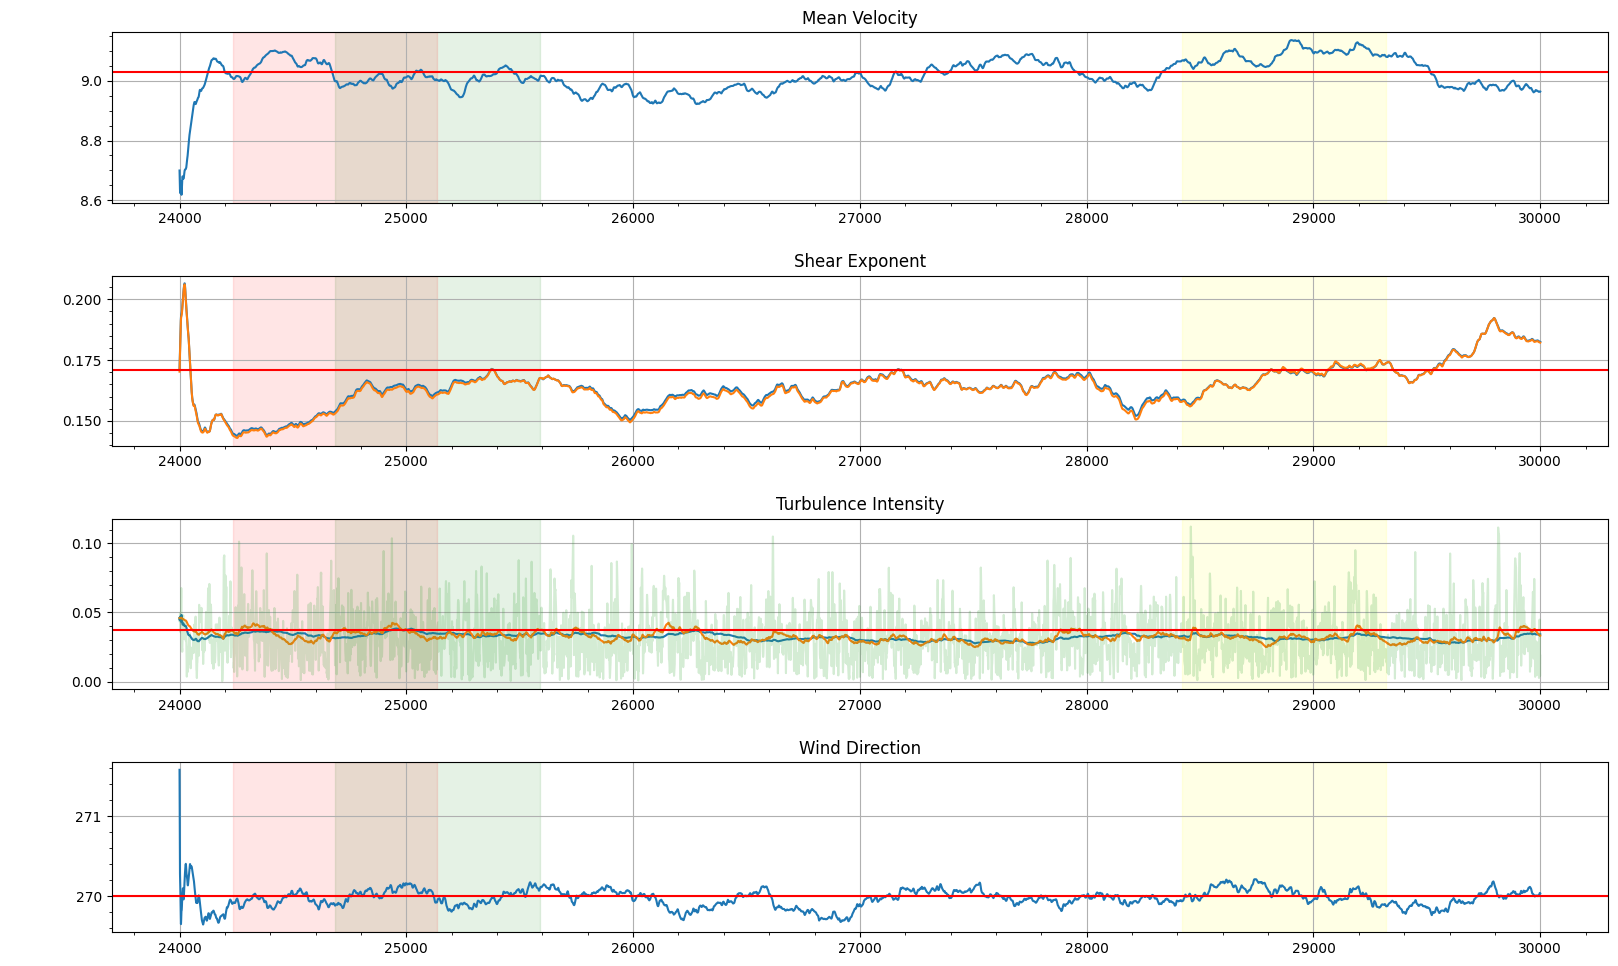

In [11]:
tm = 900  #Size of time-windows to average over. Should this also be size of searching window?
best_sep = tm/2.0 #should this be half of tm?
bin_size = bl*dt

plData = {}
plData['Time'] = prT
plData['Umag'] = Umag_hh
plData['Alpha'] = alpha_inst
plData['Alpha-Fit'] = alpha_fit
plData['WindDir'] = windDir_hh
#plData['TI'] = precTotTI_inst
plData['TI'] = precResTI_inst
maData = pd.DataFrame(plData)


umag_roll = maData['Umag'].rolling(tm,min_periods=1).mean()
alpha_roll = maData['Alpha'].rolling(tm,min_periods=1).mean()
alpha_fit_roll = maData['Alpha-Fit'].rolling(tm,min_periods=1).mean()
ti_ewa = maData['TI'].ewm(alpha=0.005, adjust=False).mean()
ti_roll = maData['TI'].rolling(tm,min_periods=1).mean()
windDir_roll = maData['WindDir'].rolling(tm,min_periods=1).mean()

fig, ax = plt.subplots(4,1, figsize=(16, 10))  

ax[0].plot(prT,umag_roll)
ax[1].plot(prT,alpha_roll)
ax[1].plot(prT,alpha_fit_roll)
ax[2].plot(prT,ti_roll)
ax[2].plot(prT,ti_ewa)
ax[2].plot(prT,maData['TI'],alpha=0.2)
ax[3].plot(prT,windDir_roll)

cbest = np.array([searchDataSort['Time'][0]])
c = 0

for i,s in enumerate(searchDataSort['Time']):
    if c == 0:
        cond1 = (searchDataSort['Time'][i]>(cbest[c]+best_sep))
        cond4 = (searchDataSort['Time'][i]<(cbest[c]-best_sep))
        if( cond1 | cond4):
            cbest = np.append(cbest,searchDataSort['Time'][i])
            c = c + 1
        if(c>=2):
            break
    if c > 0:
        cond1 = (searchDataSort['Time'][i]>(cbest[c]+best_sep))
        cond2 = (searchDataSort['Time'][i]>(cbest[c-1]+best_sep))
        cond3 = (searchDataSort['Time'][i]<(cbest[c]-best_sep))
        cond4 = (searchDataSort['Time'][i]<(cbest[c-1]-best_sep))
        if((cond1 & cond2) | (cond3 & cond4)):
            cbest = np.append(cbest,searchDataSort['Time'][i])
            c = c + 1
        if(c>=2):
            break


print("Best three bins: " + str(cbest))
print("1: Green, 2: Yellow, 3: Red")

for i,a in enumerate(ax):
    a.axvspan(cbest[0], cbest[0]+bin_size, alpha=0.1, color='green')
    a.axvspan(cbest[1], cbest[1]+bin_size, alpha=0.1, color='yellow')
    a.axvspan(cbest[2], cbest[2]+bin_size, alpha=0.1, color='red')
    

#Plot Target parameters
ax[0].axhline(y=expU,color='r')
ax[1].axhline(y=expShear,color='r')
ax[2].axhline(y=expTI,color='r')
ax[3].axhline(y=expWS,color='r')

ax[0].set_title("Mean Velocity")
ax[1].set_title("Shear Exponent")
ax[2].set_title("Turbulence Intensity")
ax[3].set_title("Wind Direction")

showplot(0,0)

In [12]:
searchDataSort[searchDataSort['Time'].isin(cbest)]

,Time,Umean,Alpha,Alpha-Fit,TI_res,WindDir,Diff_metric,Umag_Stdev
0,24687.6,9.013803,0.167177,0.166917,0.034932,270.003733,0.032095,0.253963
1215,28420.8,9.079886,0.169621,0.169868,0.031315,270.014071,0.055506,0.224610
3015,24237.2,9.026687,0.159259,0.158700,0.034350,269.972724,0.063879,0.254266
